<a href="https://colab.research.google.com/github/mkbahk/QuantumComputing/blob/main/qiskit_runtime_20240321.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Qiskit Runtime은 클라우드 기반으로 제공되는 양자 컴퓨팅 서비스를 더욱 효율적으로 사용할 수 있도록 하는 프로그래밍 모델

*   Sampler를 사용할 경우 여러 양자 회로와 다른 파라미터 조합을 한 번에 실행해볼 수 있으며, 추가 옵션을 통해 오류를 완화한 결과를 도출할 수도 있습니다. 실행 결과는 지정한 shots 수로 정규화된 값이며 이는 일반적으로 Runtime을 사용하지 않고 작업을 보냈을 때 받는 값과 유사합니다.
*   Estimator를 사용할 경우 Sampler와 거의 유사하지만 실행 결과가 양자 관측가능량(observable)의 기댓값이 된다는 점에서 차이가 있습니다.




In [17]:
!python3 -m pip install qiskit[visualization]
!python3 -m pip install qiskit-ibm-runtime
!python3 -m pip install qiskit-aer
!python3 -m pip install qiskit-ionq
!python3 -m pip install qiskit-ibm-provider

  Using cached qiskit_ionq-0.5.0-py3-none-any.whl (37 kB)
  Using cached decorator-5.1.1-py3-none-any.whl (9.1 kB)
  Using cached retry-0.9.2-py2.py3-none-any.whl (8.0 kB)
  Attempting uninstall: decorator
    Found existing installation: decorator 4.4.2
    Uninstalling decorator-4.4.2:
      Successfully uninstalled decorator-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
moviepy 1.0.3 requires decorator<5.0,>=4.0.2, but you have decorator 5.1.1 which is incompatible.


In [27]:
from qiskit_ibm_runtime import QiskitRuntimeService
QiskitRuntimeService.save_account(channel="ibm_quantum", token="70a78ec522cad39dfba69fd03ee74b18bc807d50c355ef2593cf2345b2dcfcb90777ed63379c470f1c76329049d3f6b6e6ea269496849e488cb427cbd2a412f7", overwrite=True)

In [29]:
service = QiskitRuntimeService()
#service.pprint_programs()
service.backends()

[<IBMBackend('ibm_osaka')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyoto')>]

In [30]:
from qiskit import QuantumCircuit

circuit = QuantumCircuit(5)

circuit.h(0)

for i in range(0, 4):
    circuit.cx(i, i + 1)

circuit.measure_all()
circuit.draw()


┌───┐                     ░ ┌─┐            
   q_0: ┤ H ├──■──────────────────░─┤M├────────────
        └───┘┌─┴─┐                ░ └╥┘┌─┐         
   q_1: ─────┤ X ├──■─────────────░──╫─┤M├─────────
             └───┘┌─┴─┐           ░  ║ └╥┘┌─┐      
   q_2: ──────────┤ X ├──■────────░──╫──╫─┤M├──────
                  └───┘┌─┴─┐      ░  ║  ║ └╥┘┌─┐   
   q_3: ───────────────┤ X ├──■───░──╫──╫──╫─┤M├───
                       └───┘┌─┴─┐ ░  ║  ║  ║ └╥┘┌─┐
   q_4: ────────────────────┤ X ├─░──╫──╫──╫──╫─┤M├
                            └───┘ ░  ║  ║  ║  ║ └╥┘
meas: 5/═════════════════════════════╩══╩══╩══╩══╩═
                                     0  1  2  3  4

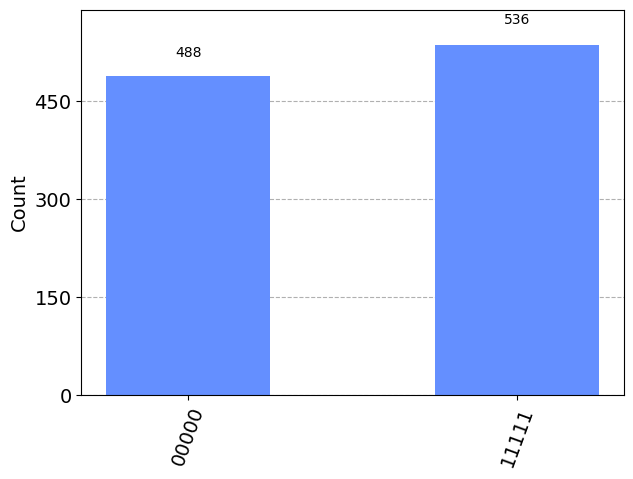

In [31]:
from qiskit_aer import Aer

backend = Aer.get_backend('qasm_simulator')
result = backend.run(circuit,shots = 1024).result()
counts = result.get_counts()

from qiskit.visualization import plot_histogram
plot_histogram(counts)

Qiskit Runtime의 Sampler와 함께 해당 회로를 qasm_simulator로 측정해봅시다. 이때 사용 가능한 백엔드로는 위에서 실행해본 service.backends()으로부터 확인하실 수 있습니다.

In [34]:
from qiskit_ibm_runtime import QiskitRuntimeService

options = {
#	'backend_name': 'ibmq_qasm_simulator'
}

runtime_inputs = {
	'circuit_indices': [0],
	'circuits': circuit
}

service = QiskitRuntimeService(
	channel='ibm_quantum'
)

job = service.run(
	program_id='sampler',
	options=options,
	inputs=runtime_inputs,
#	instance='ibm-q/open/main'
)

print(job.job_id)
print(job.status())

result = job.result()
plot_histogram(result.get('quasi_dists'))


IBMInputValueError: '"backend" is required field in "options" for "ibm_quantum" channel.'

In [24]:
from qiskit_ibm_runtime import Sampler

options = {
	'backend_name': 'ibmq_qasm_simulator'
}

resilience_settings = {
	"level": 1
}

result = None
with Sampler([circuit], service=service, options=options, resilience_settings=resilience_settings) as sampler:
	result = sampler([circuit])

plot_histogram(result.quasi_dists)


TypeError: SamplerV1.__init__() got an unexpected keyword argument 'service'